** Objectives **

* How to load a large file into memory using Pandas ?
* How to take a representative sample from a population ?
    * Stratified sample

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

basepath = os.path.expanduser('~/Desktop/src/Loan_Default_Prediction/')
sys.path.append(os.path.join(basepath, 'src'))

** Stratified Sample **

In [2]:
def get_stratified_sample(X, y, train_size, random_state=10):
    """
    Takes in a feature set and target with percentage of training size and a seed for reproducability.
    Returns indices for the training and test sets.
    """
    
    itrain, itest = train_test_split(range(len(X)), stratify=y, train_size=train_size, random_state=random_state)
    return itrain, itest

In [12]:
# load files
chunksize = 10 ** 4

train_chunks = pd.read_table(os.path.join(basepath, 'data/raw/train_v2.csv'), \
                             chunksize=chunksize, \
                             sep=',', \
                             index_col='id'
                            )

In [13]:
train = pd.concat(train_chunks)

In [14]:
# create a binary variable based on the target
train['is_default'] = (train.loss > 0).astype(np.int)

In [15]:
itrain, itest = get_stratified_sample(train, train.is_default, 0.4)

train_sample = train.iloc[itrain]

In [18]:
train_sample.shape

(42188, 771)

In [19]:
print('Shape of the sample: ', (train_sample.shape))

Shape of the sample:  (42188, 771)


In [20]:
def unique_values(df, features):
    return {feature: df[feature].nunique() for feature in features}

def get_features_std(df):
    # select numerical features
    numerical_columns = df.select_dtypes(exclude=['object']).columns
    
    return {col:df[col].std() for col in numerical_columns}
        

def get_features_with_single_val(feature_dict):
    return [k for k, v in feature_dict.items() if v == 1]

In [22]:
features = train_sample.columns.drop(['is_default', 'loss'])

In [23]:
feature_dict_train = unique_values(train_sample, features)
# feature_dict_test  = unique_values(test, features)

In [24]:
features_with_single_val_train = get_features_with_single_val(feature_dict_train)
# features_with_single_val_test  = get_features_with_single_val(feature_dict_test)

In [25]:
features_std_train = get_features_std(train_sample)
# features_std_test  = get_features_std(test)

** Features in training set which take a single value. **

In [26]:
print(features_with_single_val_train)

['f38', 'f736', 'f764', 'f678', 'f34', 'f702', 'f701', 'f33', 'f700', 'f37', 'f35']


** Features in the training set which have zero standard deviation. **

In [27]:
list(filter(lambda x: features_std_train[x] == 0, features_std_train.keys()))

['f38',
 'f736',
 'f764',
 'f678',
 'f34',
 'f702',
 'f701',
 'f33',
 'f700',
 'f37',
 'f35']

** Histogram of features ( training set ). **

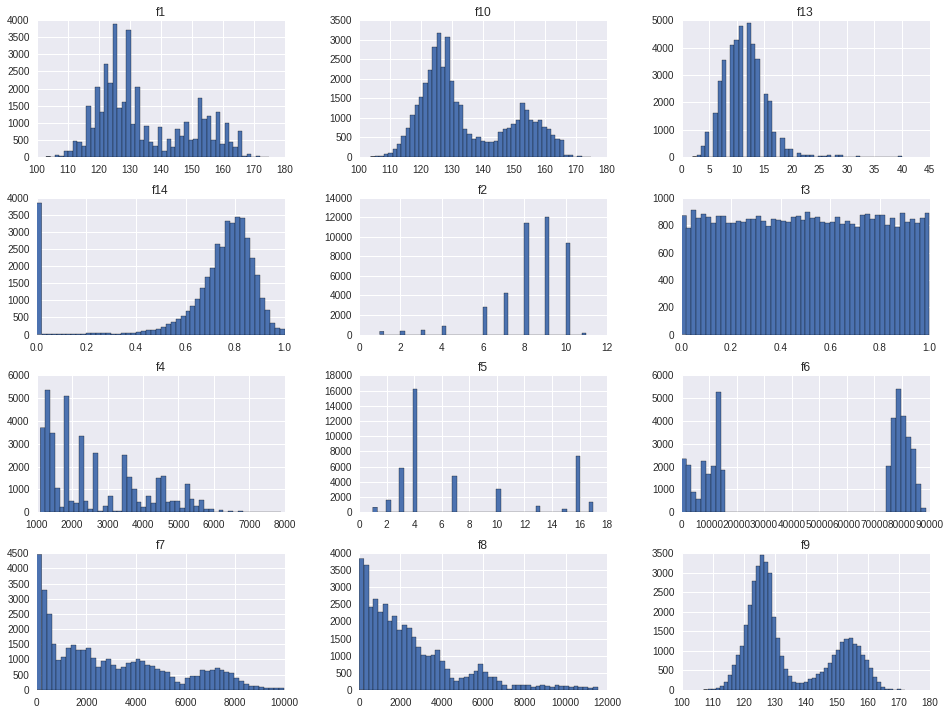

In [30]:
train_sample.ix[:, :12].hist(figsize=(16, 12), bins=50);

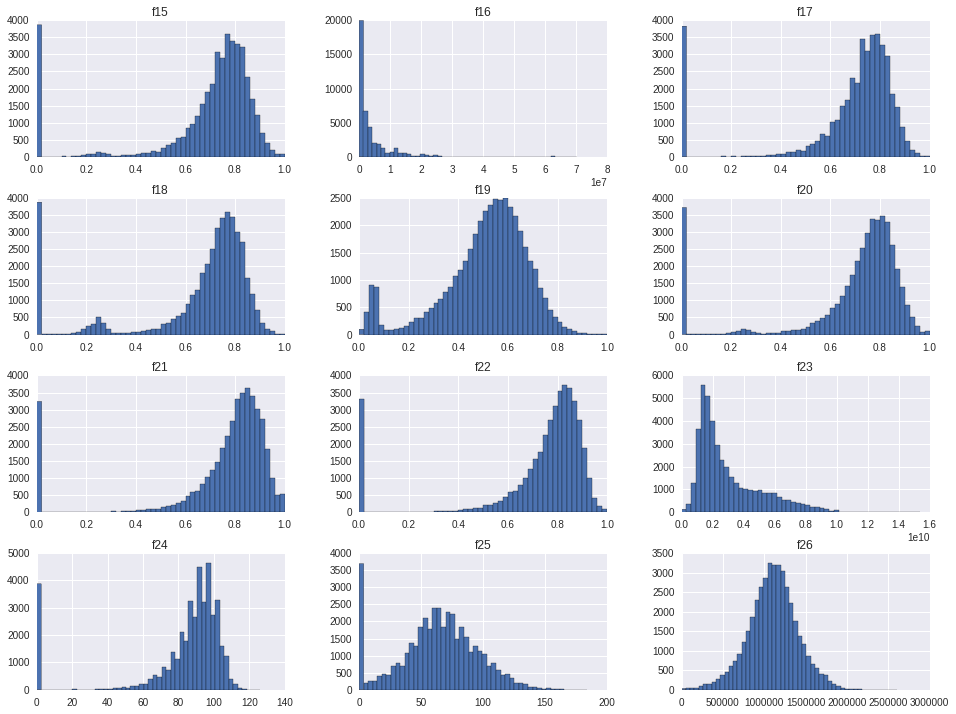

In [31]:
train_sample.ix[:, 12:24].hist(figsize=(16, 12), bins=50);

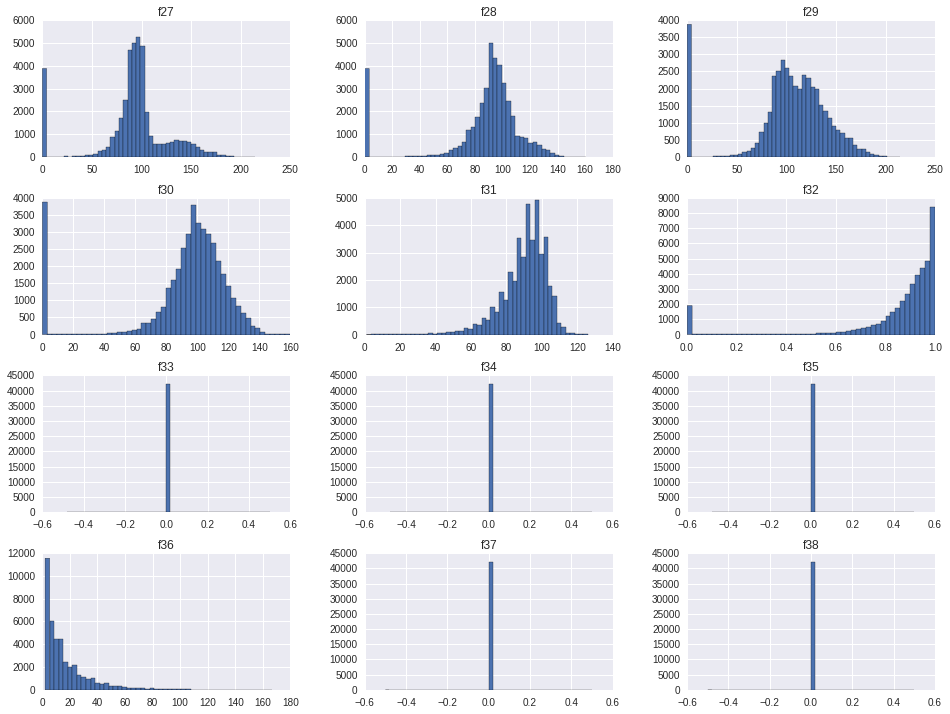

In [32]:
train_sample.ix[:, 24:36].hist(figsize=(16, 12), bins=50);

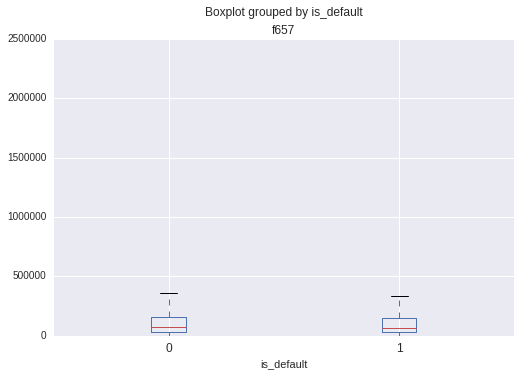

In [37]:
# correlation with target variable
train_sample.boxplot(column='f657', by='is_default');

In [15]:
class FeatureExtractor:
    def __init__(self, train, test):
        self.train = train
        self.test  = test
    
    def extract(self):
        self.round_values()
        self.create_features()
        
        return self.get_train(), self.get_test()
    
    def round_values(self):
        self.train = np.around(self.train, decimals=1)
        self.test  = np.around(self.test, decimals=1)
    
    def create_features(self):
        # feature based out of f1
        self.train['f1_cat'] = (self.train['f1'] < 140).astype(np.int)
        self.test['f1_cat']  = (self.test['f1'] < 140).astype(np.int)
        
        # feature based out of f9
        self.train['f9_cat'] = (self.train['f9'] < 140).astype(np.int)
        self.test['f9_cat']  = (self.test['f9'] < 140).astype(np.int)
        
        # feature based out of 10
        self.train['f10_cat'] = (self.train['f10'] < 140).astype(np.int)
        self.test['f10_cat']  = (self.test['f10'] < 140).astype(np.int)
        
        # feature out of f14
        self.train['f14_cat'] = (self.train['f14'] == 0.0).astype(np.int)
        self.test['f14_cat']  = (self.test['f14'] == 0.0).astype(np.int)
        
        # feature out of f6
        self.train['f6_cat'] = (self.train['f6'] < 2e4).astype(np.int)
        self.test['f6_cat']  = (self.test['f6'] < 2e4).astype(np.int)
         
    def get_train(self):
        return self.train
    
    def get_test(self):
        return self.test

In [16]:
feat = FeatureExtractor(train[train.columns[:12]], test[test.columns[:12]])
train_sub, test_sub = feat.extract()

In [20]:
train_sub.to_csv(os.path.join(basepath, 'data/processed/train_sub.csv'), index=False)
test_sub.to_csv(os.path.join(basepath, 'data/processed/test_sub.csv'), index=False)

train[['loss']].to_csv(os.path.join(basepath, 'data/processed/target.csv'), index=False)